## Module Import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

## Data Load

In [2]:
train = pd.read_csv('D:/data/새 폴더/_Noise data/Si_ 3 times0_1_11_30000.csv',
                    encoding = 'cp949', skiprows = 11, names = [0])

In [3]:
train

,0
0,0.016479
1,0.015259
2,0.014038
3,0.012817
4,0.015869
...,...
15355,0.000000
15356,0.000000
15357,0.000000
15358,0.000000


## EDA

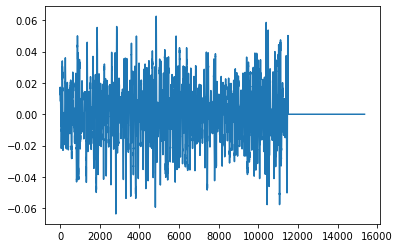

<Figure size 576x72 with 0 Axes>

In [4]:
plt.plot(train)
plt.figure(figsize=(8, 1))
plt.show()

* 유사한 구간에서 0이되는 것을 확인

In [5]:
train[11500:]

,0
11500,0.0
11501,0.0
11502,0.0
11503,0.0
11504,0.0
...,...
15355,0.0
15356,0.0
15357,0.0
15358,0.0


* 0인 부분 제거

In [6]:
train = train[:11500]

In [7]:
train

,0
0,0.016479
1,0.015259
2,0.014038
3,0.012817
4,0.015869
...,...
11495,0.050049
11496,0.049438
11497,0.050201
11498,0.048218


* 11500 seq부터 모든 값이 0

### Test data Load

In [8]:
valid = pd.read_csv('D:/data/새 폴더/_Noise data/Si_ 3 times0_1_15_42000.csv',
                    encoding = 'cp949', skiprows = 11, names = [0])

In [9]:
valid

,0
0,-0.014648
1,-0.014343
2,-0.014038
3,-0.013733
4,-0.014496
...,...
15355,0.000000
15356,0.000000
15357,0.000000
15358,0.000000


In [10]:
valid = valid[:11500]

#### Scaling은 성능 하락으로 제거

### Sequence split

In [11]:
def truncate(x, train_len=20, test_len=1):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len +1):
        in_.append(x[i:(i+train_len)].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len)].tolist())
    return np.array(in_), np.array(out_)

### train 분할

In [12]:
train = np.array(train)

In [13]:
valid = np.array(valid)

In [14]:
X_train , y_train = truncate(train)

In [15]:
X_train.shape

(11480, 20, 1)

In [16]:
X_train

array([[[0.01647949],
        [0.01525879],
        [0.01403809],
        ...,
        [0.00823975],
        [0.0100708 ],
        [0.01266479]],

       [[0.01525879],
        [0.01403809],
        [0.01281738],
        ...,
        [0.0100708 ],
        [0.01266479],
        [0.01266479]],

       [[0.01403809],
        [0.01281738],
        [0.01586914],
        ...,
        [0.01266479],
        [0.01266479],
        [0.01327515]],

       ...,

       [[0.02853394],
        [0.0302124 ],
        [0.03097534],
        ...,
        [0.05020142],
        [0.05004883],
        [0.04943848]],

       [[0.0302124 ],
        [0.03097534],
        [0.03067017],
        ...,
        [0.05004883],
        [0.04943848],
        [0.05020142]],

       [[0.03097534],
        [0.03067017],
        [0.03265381],
        ...,
        [0.04943848],
        [0.05020142],
        [0.04821777]]])

In [17]:
X_valid , y_valid = truncate(valid)

In [18]:
X_train = X_train.reshape(-1, 20, 1)
y_train = y_train.reshape(-1, 1, 1)
X_valid = X_valid.reshape(-1, 20, 1)
y_valid = y_valid.reshape(-1, 1, 1)

In [19]:
X_train

array([[[0.01647949],
        [0.01525879],
        [0.01403809],
        ...,
        [0.00823975],
        [0.0100708 ],
        [0.01266479]],

       [[0.01525879],
        [0.01403809],
        [0.01281738],
        ...,
        [0.0100708 ],
        [0.01266479],
        [0.01266479]],

       [[0.01403809],
        [0.01281738],
        [0.01586914],
        ...,
        [0.01266479],
        [0.01266479],
        [0.01327515]],

       ...,

       [[0.02853394],
        [0.0302124 ],
        [0.03097534],
        ...,
        [0.05020142],
        [0.05004883],
        [0.04943848]],

       [[0.0302124 ],
        [0.03097534],
        [0.03067017],
        ...,
        [0.05004883],
        [0.04943848],
        [0.05020142]],

       [[0.03097534],
        [0.03067017],
        [0.03265381],
        ...,
        [0.04943848],
        [0.05020142],
        [0.04821777]]])

In [20]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(11480, 20, 1) (11480, 1, 1) (11480, 20, 1) (11480, 1, 1)


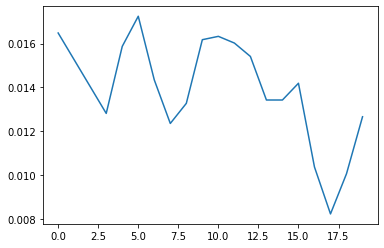

In [21]:
plt.plot(X_train[0])
plt.show()

## Model

In [22]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [23]:
n_hidden = 100

In [24]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(y_train.shape[1], X_train.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [25]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(n_hidden,
                                          activation='relu', 
                                          dropout=0.3, 
                                          recurrent_dropout=0.3,
                                          return_sequences=False,
                                          return_state=True)(input_train)

In [26]:
output_train.shape[1]

1

In [27]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

In [28]:
decoder

<KerasTensor: shape=(None, 1, 100) dtype=float32 (created by layer 'repeat_vector')>

In [30]:
decoder = LSTM(n_hidden,
               activation='relu', 
               dropout=0.3, 
               recurrent_dropout=0.3,
               recurrent_regularizer=l2(0.01),
               return_sequences=True,
               return_state=False)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 100), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")


In [31]:
out= TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [32]:
model = Model(inputs = input_train, outputs = out)
opt = Adam(learning_rate=0.01, )
# gradient cliping : https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover-6/05-gradient-clipping
model.compile(loss='mean_squared_error', optimizer = opt, metrics = ['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        40800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 1, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 5)
# early stopping
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                    epochs=30, verbose = 1 , callbacks=[es],
                    batch_size=64)

Epoch 1/30
178/180 [============================>.] - ETA: 0s - loss: 0.0495 - mae: 0.0080

In [ ]:
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

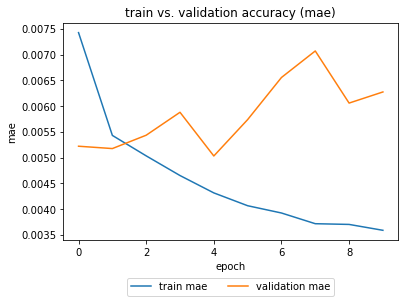

In [35]:
plt.plot(train_mae, label='train mae')
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## test

In [36]:
test = pd.read_csv('D:/data/새 폴더/_Noise data/Si_ 3 times0_1_56282_180119583.csv',encoding = 'cp949', skiprows = 11, names = [0])

In [37]:
test

,0
0,-0.014038
1,-0.013123
2,-0.012207
3,-0.011291
4,-0.009003
...,...
15355,0.000000
15356,0.000000
15357,0.000000
15358,0.000000


In [38]:
test = np.array(test)

In [39]:
X_test , y_test = truncate(test)

In [40]:
test_prediction = model.predict(X_test)

480/480 [==============================] - 3s 5ms/step


In [41]:
prediction = test_prediction.squeeze()

In [42]:
len(prediction)

15340

In [43]:
len(test)

15360

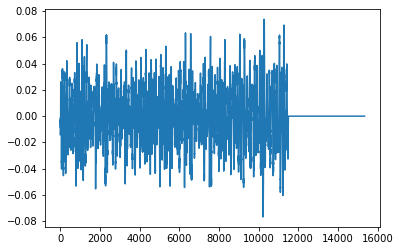

In [45]:
plt.plot(test[:15340])

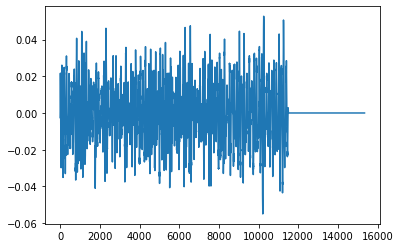

In [46]:
plt.plot(prediction)

### 일부 구간 확인

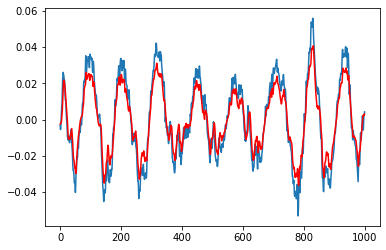

In [47]:
plt.plot(test[20:1020])
plt.plot(prediction[:1000], color= 'red')
plt.show()

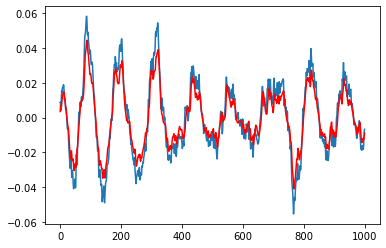

In [48]:
plt.plot(test[1020:2020])
plt.plot(prediction[1000:2000], color= 'red')
plt.show()